In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

C:\Users\User\anaconda3\envs\mlos\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


# Bayesian Optimization

This notebook demonstrates the basic principles of [Bayesian Optimization (BO)](https://en.wikipedia.org/wiki/Bayesian_optimization) and how to use MLOS to perform BO.

## Motivation

In software performance engineering, the impact different (input) parameters (e.g. buffer size, worker thread count, etc.) can have on the (output) performance of a system for a given workload (input) can be modeled as a multidimensional function - one which we don't know the equation for apriori, but are instead trying to learn through careful sampling of the input space and experimentation (test/benchmark runs) to gather output points.
Bayesian optimization is one technique for efficiently selecting the samples in the input space to learn the approximate shape of that function and find its optimum, i.,e. the parameters that lead to the best performance.
In this example we use a synthetic (i.e. made-up) function that we can look at directly to stand in for a complex system with unknown characteristics.

Bayesian Optimization is a [global optimization](https://en.wikipedia.org/wiki/Global_optimization) strategy, so a way to find the global optimum of a mathematical function that's not necessarily [convex](https://en.wikipedia.org/wiki/Convex_function). BO is a black-box optimization technique, meaning that it requires only function values and no other information like gradients.

This is in contrast to other optimization strategies, such as gradient descent or conjugate gradient that require gradients and are only guaranteed to find a local optimum (if the function is assumed to be convex, this is also the global optimum).

Finding the global optimum of a general non-convext function is NP-hard, which makes it impossible to provide effective convergence guarantees for any global optimization strategy, including Bayesian Optimization. However, BO has been found to be quite effective in the past.

## A synthetic example

Let's take a simple synthetic example of a one-dimensional function that we assume is unknown.
If we actually had access to the function, we could use more efficient techniques using calculus and would not be using Bayesian Optimization.

In [2]:
# define fake performance function
# In an actual application, we would not have access to this function directly.
# Instead, we could only measure the outcome by running an experiment, such as timing
# a particular run of the system.
def f(x):
    return (6*x-2)**2*np.sin(12*x-4)

In a real use case for global optimization, the function we want to optimize is usually only implicitly defined and very expensive to compute, such as training and evaluating a neural network, or timing the run of a large workload on a distributed database. Given the cost of evaluating the function, our goal is to find an optimum while keeping the number of function evaluations to a minimum.

In this synthetic example, we actually know the function, so we can just plot it for illustration purposes:

Text(0, 0.5, 'Objective (i.e. performance)')

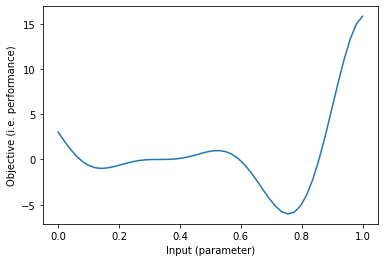

In [3]:
# define a domain to evaluate
line = np.linspace(0, 1)
# evaluate function
values = f(line)
# plot function
plt.plot(line, values)
plt.xlabel("Input (parameter)")
plt.ylabel("Objective (i.e. performance)")

Our goal here is to find the global minimum of this function, assuming that we don't have direct access to the formula (given the formula, we could instead calculate the optimum quite precicely using methods from calculus instead). Usually, the function is too expensive to evaluate in such a manner, in particular in higher-dimensional spaces.

Now, we use MLOS to construct an OptimizationProblem object that will encapsulate the function and the input space.

In [4]:
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Spaces import SimpleHypergrid, ContinuousDimension

# single continuous input dimension between 0 and 1
input_space = SimpleHypergrid(name="input", dimensions=[ContinuousDimension(name="x", min=0, max=1)])
# define output space, we might not know the exact ranges
output_space = SimpleHypergrid(name="objective",
                               dimensions=[ContinuousDimension(name="function_value", min=-10, max=10)])

# define optimization problem with input and output space and objective
optimization_problem = OptimizationProblem(
    parameter_space=input_space,
    objective_space=output_space,
    # we want to minimize the function
    objectives=[Objective(name="function_value", minimize=True)]
)

The way Bayesian Optimization (in particular what is known as sequential model-based optimization) works is by iterating the following steps:
- Evaluate the function at a candidate point x_i (start with a random point x_0), observe f(x_i).
- Build / update a **surrogate model** g_i of the objective function (here a Random Forest) using the pairs x_i, f(x_i) that we observed so far.
- Pick the next data point to evaluate based on the updated model g_i using a criterion known as **acquisition function**.

The idea is that eventually the surrogate model will provide a good approximation of the objective function, but it will be much faster to evaluate (i.e. by predicting with a Random Forest or Gaussian process or another trained machine learning model, instead of running a complex deployment). The acquisition function serves as a means to trade off exploration vs exploitation in collecting new data for building the surrogate model: it picks points that have a low (close to optimum) value of the surrogate model (and so are expected to have a low value of the actual objective). This is the "exploitation" of existing knowledge in the model. On the other hand, it also encourages exploring new areas in which there is a lot of uncertainty in the surrogate model, i.e. where we expect the surrogate model not to be very acurate yet.

This process is coordinated by the ``BayesianOptimizer`` object, which we will use to performe Bayesian Optimization with a random forest surrogate model. Details of this particular method can be found in [Hutter et. al. (2011)](https://www.cs.ubc.ca/~hutter/papers/11-LION5-SMAC.pdf). We're first configuring the model to refit after every iteration and use 10 trees for the random forest:

In [5]:
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer, BayesianOptimizerConfig
from mlos.Optimizers.RegressionModels.HomogeneousRandomForestRegressionModel import HomogeneousRandomForestRegressionModelConfig

from mlos.Spaces import Point

optimizer_config = BayesianOptimizerConfig.DEFAULT.copy()
optimizer_config.experiment_designer_config_fraction_random_suggestions = .1
random_forest_config = optimizer_config.homogeneous_random_forest_regression_model_config

random_forest_config.decision_tree_regression_model_config.n_new_samples_before_refit = 1
random_forest_config.decision_tree_regression_model_config.splitter = 'best'
# right now we're sampling without replacement so we need to subsample to make the trees different when using the 'best' splitter
random_forest_config.samples_fraction_per_estimator = .9
random_forest_config.n_estimators = 10

optimizer_config.experiment_designer_config.confidence_bound_utility_function_config.alpha = 0.1

optimizer = BayesianOptimizer(optimization_problem, optimizer_config)

Now, we can run the actual optimization which will carry out the steps outlined above.

In [6]:
def run_optimization(optimizer):
    # suggest new value from optimizer
    suggested_value = optimizer.suggest()
    input_values_df = suggested_value.to_pandas()
    # suggested value are dictionary-like, keys are input space parameter names
    # evaluate target function
    target_value = f(suggested_value['x'])
    print(suggested_value, target_value)
    
    # build dataframes to 
    target_values_df = pd.DataFrame({'function_value': [target_value]})

    optimizer.register(input_values_df, target_values_df)

# run for some iterations
n_iterations = 15
for i in range(n_iterations):
    run_optimization(optimizer)

{'x': 0.17541269264801218} -0.8510165603918378
{'x': 0.480913709175287} 0.7684232406186272
{'x': 0.9660637353049126} 13.923595514697766
{'x': 0.599688110301572} -0.13954487638915977
{'x': 0.657252197967745} -2.562068656075098
{'x': 0.47930657081517725} 0.7545797874976039
{'x': 0.5572369124188329} 0.7927275526767186
{'x': 0.4169790550228403} 0.2124565622737972
{'x': 0.9438161727442966} 11.588396700551597
{'x': 0.24679271856398266} -0.23230954552916283
{'x': 0.29127300320772354} -0.030796649398039954
{'x': 0.7568094096313009} -6.020637107900314
{'x': 0.6908058262545883} -4.195382551491563
{'x': 0.6477011549497518} -2.0984055031109357
{'x': 0.7433805673602539} -5.922305077352223


After 15 iterations, the model is likely to have captured the general shape, but probably not have found the actual optimum:

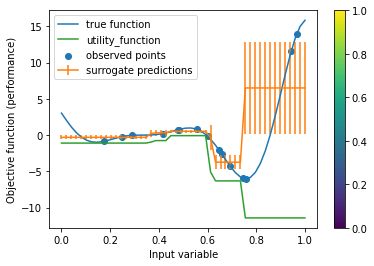

In [7]:
# evaluate the surrogate
surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line})).get_dataframe()
# plot observations
feature_values, target_values = optimizer.get_experiment_data()
plt.scatter(feature_values, target_values, label='observed points')
plt.colorbar()
# plot true function (usually unknown)
plt.plot(line, values, label='true function')
# plot the surrogate
plt.errorbar(x=line, y=surrogate_predictions['sample_mean'], yerr=np.sqrt(surrogate_predictions['predicted_value_variance']), label='surrogate predictions')
plt.plot(line, -optimizer.experiment_designer.utility_function(pd.DataFrame({'x': line})), label='utility_function')
plt.ylabel("Objective function (performance)")
plt.xlabel("Input variable")
plt.legend()

We can run more iterations to improve the surrogate model and the optimum that is found:

In [8]:
# run for more iterations
n_iterations = 50
for i in range(n_iterations):
    run_optimization(optimizer)

{'x': 0.990244796357477} 15.528663885353051
{'x': 0.8468123963783023} -1.149818963184237
{'x': 0.32349771403934435} -0.00041009085764023455
{'x': 0.8295080411981345} -2.864292692101212
{'x': 0.47721820815824323} 0.7362729711107432
{'x': 0.8501046147740627} -0.7867845959128675
{'x': 0.8723116166543465} 1.9191130091826887
{'x': 0.43309703228313956} 0.3335807052033726
{'x': 0.8958663351666696} 5.130913179766662
{'x': 0.8457450075246016} -1.2651269538818555
{'x': 0.7981593061357506} -5.042205937853623
{'x': 0.8388311491738134} -1.9824555853022836
{'x': 0.9912250677338543} 15.568659488374738
{'x': 0.3505657324285757} 0.0021949335020925286
{'x': 0.8041568279966457} -4.722822309178047
{'x': 0.6545934861891199} -2.431811590661345
{'x': 0.9328090948141843} 10.21825424923689
{'x': 0.8061682762253998} -4.605291088556691
{'x': 0.9142560906765052} 7.713459555417368
{'x': 0.5913370187988589} 0.10911326060041696
{'x': 0.7070208052769921} -4.896865470186089
{'x': 0.6842696181487558} -3.888418213952711

We can now visualize the surrogate model and optimization process again. The points are colored according to the iteration number, with dark blue points being early in the process and yellow points being later. You can see that at the end of the optimization, the points start to cluster around the optimum.

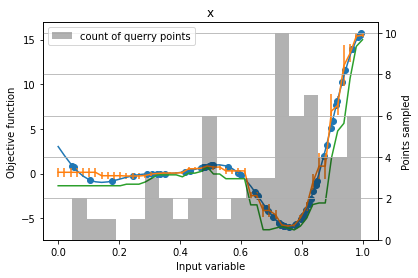

In [9]:
# evaluate the surrogate
surrogate_predictions = optimizer.predict(pd.DataFrame({'x': line})).get_dataframe()
# plot observations
feature_values, target_values = optimizer.get_experiment_data()
plt.scatter(feature_values, target_values, label='observed points')

# plot true function (usually unknown)
plt.plot(line, values, label='true function')
# plot the surrogate
plt.errorbar(x=line, y=surrogate_predictions['sample_mean'], yerr=np.sqrt(surrogate_predictions['predicted_value_variance']), label='surrogate predictions')
plt.plot(line, -optimizer.experiment_designer.utility_function(pd.DataFrame({'x': line})), label='utility_function')
ax = plt.gca()
ax.set_ylabel("Objective function")
ax.set_xlabel("Input variable")
bins_axes = ax.twinx()
bins_axes.set_ylabel("Points sampled")
optimizer._feature_values_df.hist(bins=20, ax=bins_axes, alpha=.3, color='k', label="count of querry points")
plt.legend()